In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Load data and get mask

In [2]:
rootdir = '/data/staff/common/data/pd'
datafilename = 'LaB6_ref_carmen_data_000001.h5'
filename = os.path.join(rootdir,datafilename)
data_path = '/entry/data/data'
print('%s:%s' % (filename,data_path ,))

/data/staff/common/data/pd/LaB6_ref_carmen_data_000001.h5:/entry/data/data


In [3]:
data = None

with h5py.File(filename,'r') as h5f:
    data = h5f[data_path][()]
    data = np.squeeze(data)
    
print(data.shape)

(1065, 1030)


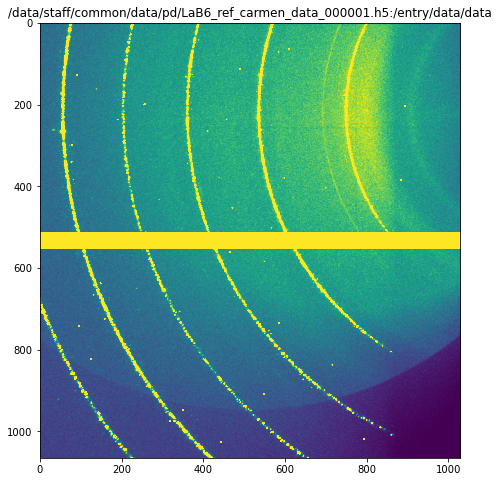

In [4]:
# get estimate of max range ignoring very high values
vmax=np.percentile(data[data<1000000],98)

plt.figure(figsize=(8,8))
plt.imshow(data, vmax=vmax)
plt.title('%s:%s' % (filename,data_path ,));

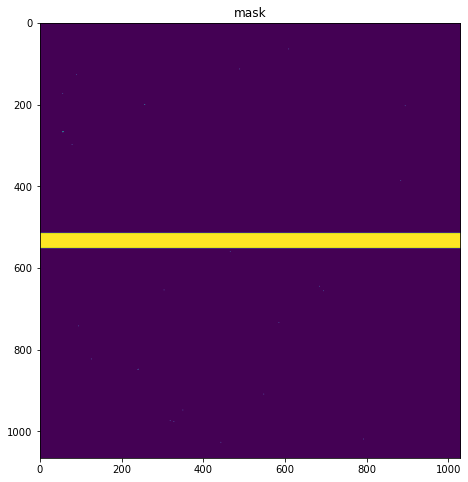

In [5]:
# create mask
# Note: in photon science UINT is often used as data typy,
#       however special values are used to label e.g.
#       -1 ... detector gaps, -2 ... masked hot pixels etc.,
#       moreover there are unmasked hot pixels showing usually
#       very high random values
mask = np.logical_or(data==np.uint32(-1),data==np.uint32(-2))
vmax = np.percentile(data[~mask],99.999)
mask = np.logical_or(mask, data>vmax)

img = data.copy()
img[mask] = 0

plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.title('mask');

## Check calibration parameters

- *Clemens* and *Justus* should have the original calibration file
- this is standrd $LaB_6$ measurement, one can do the calibration yourself, e.g. with *pyFAI* or *Fit2D*
- note: Carmen's *xtrace* code does not include detector tilt yet
- some values were found in Carmen's Python code, in particular: pixelcorrections2Dv1.py (2021, Sep 17)

In [6]:
# pixelcorrections2Dv1.py ... likely some scaled testing values

# pixel dimentions
pl = 75  # pixel length, in micrometers 
pw = 450 # pixel width, in micrometers
ph = 75  # pixel height, in micrometers

# Cartesian coordinates of the sample, given by the poni file 
sx = -0.4051247560395305 * 10**4 # -dist in poni file, in micrometers
sy = 0.17601077769492505 * 10**4 # P2 in poni file, in micrometers
sz = 0.02184240399163788 * 10**4 # P1 in poni file, in micrometers

# in pixel coordinates
sy_pix = sy/pl
sz_pix = sz/ph

In [7]:
# /data/staff/common/data/pd/LaB6_ref_carmen_data_000001_pyFAI_no_tilt.poni
# ... calibration by Zdenek using pyFAI, Jan 4, 2022
#     no tilt, refined energy close to 13 keV

## Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
## Calibration done at Tue Jan  4 17:25:49 2022
#poni_version: 2
#Detector: Eiger1M
#Detector_config: {}
#Distance: 0.15440269217351899
#Poni1: 0.01614699850343882
#Poni2: 0.09233769557958088
#Rot1: 0.0
#Rot2: 0.0
#Rot3: 0.0
#Wavelength: 9.537204867449691e-11

# Cartesian coordinates of the sample, given by the poni file 
sx = -0.15440269217351899 * 10**6 # -dist in poni file, in micrometers
sy =  0.09233769557958088 * 10**6 # P2 in poni file, in micrometers
sz =  0.01614699850343882 * 10**6 # P1 in poni file, in micrometers

wlen = 0.9537204867449691 # Wavelength in Å

# in pixel coordinates
sy_pix = sy/pl
sz_pix = sz/ph

In [8]:
# helper libraries for azimuthal integration geometry from Max-Lab bli711
import maxpy_erda as mp

# note: pyFAI is needed only for poni->Fit2D->bli711 calibration translation
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

deg2rad = np.pi/180.
rad2deg = 180./np.pi

ai = AzimuthalIntegrator() # new integrator
ai.setPyFAI(pixel1=ph*1e-6, pixel2=pl*1e-6,
            dist=0.15440269217351899,
            poni1=0.01614699850343882, poni2=0.09233769557958088,
            rot1=0., rot2=0., rot3=0.,
            splineFile=None)

# convert detector parameters from Carmen's (pyFAI-like) notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()
det_params_b711 = { 'n0': pf2d['centerY'], 'm0': pf2d['centerX'], \
                    'wn': (pf2d['pixelY']*1e-3/pf2d['directDist']), 'wm': (pf2d['pixelX']*1e-3/pf2d['directDist']), \
                    'phi': 0*np.pi/2, \
                    'n': data.shape[0], 'm': data.shape[1], \
                    'rot': pf2d['tiltPlanRotation']*deg2rad , 'tilt': pf2d['tilt']*deg2rad }

print("--- bli711 notation ---")
print(det_params_b711)

--- bli711 notation ---
{'n0': 215.2933133791843, 'm0': 1231.1692743944118, 'wn': 0.00048574282575147333, 'wm': 0.00048574282575147333, 'phi': 0.0, 'n': 1065, 'm': 1030, 'rot': 0.0, 'tilt': 0.0}


In [9]:
# here we describe the LaB6 stadard and calculate line positions in 2theta
# for a given wavelenght using the Bragg's law

# we need to know the interplanar distances directly
# or calculate them from reflection indices and the lattice constant

# one could genrate the indices but we can simply read them from a reference ICSD record
# note: 2Theta positios are likely for a different wavelength
# header: H K L 2THETA D-VALUE MULT INTENSITY
icsd_tbl = np.loadtxt(os.path.join(rootdir,'LaB6-icsd.txt'), skiprows=1)
hkl = icsd_tbl[:,0:3].astype(np.int32)

alat = 4.156468 # Å (tabulated)

# interplanar distances
d_hkl = alat/np.sqrt((hkl**2).sum(axis=1))

# peak positions in 2Theta (Bragg's law)
arg = wlen/2./d_hkl
lidx = arg<=1. # some reflections may be unreachable for our wavelength
d_hkl = d_hkl[lidx]
arg = arg[lidx]
tth_hkl = 2.*np.arcsin(wlen/2./d_hkl)

# we actually see 6 LaB6 lines and so we take only them
# note: some lines still may be there multiple times (in case they overlap)
nhkl = 6
hkl = hkl[:nhkl,:]
d_hkl = d_hkl[:nhkl]
tth_hkl = tth_hkl[:nhkl]

print(tth_hkl*rad2deg)

[13.17578978 18.67490535 22.92347241 26.5299217  29.72947407 32.64257361]


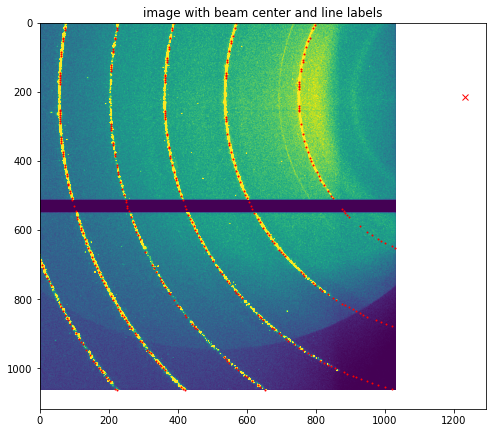

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(img, vmax=np.percentile(img,98))

# plot a cross at a beam center
plt.plot(sy_pix,sz_pix,'rx')

# mark pixels in the image that are on diffraction lines
# note: there is no function 2theta to pixel coords in maxpy_erda as it was not needed for integration

N,M = np.meshgrid(np.linspace(0, det_params_b711['n'], 200), np.linspace(0, det_params_b711['m'], 200))
tth = mp.tth2Dsimple(0.0,N,M,det_params_b711)

dtth = 0.02 * deg2rad
for ihkl in range(nhkl):
    lidx = np.logical_and(tth>=(tth_hkl[ihkl]-dtth), tth<=(tth_hkl[ihkl]+dtth))
    plt.plot(M[lidx],N[lidx],'r.',ms=2)

plt.title('image with beam center and line labels');

If the picture above looks good we have a correct calibration and good understanding of the geometry.

We can just integrate in the next step or correct and integrate.

# Corrections

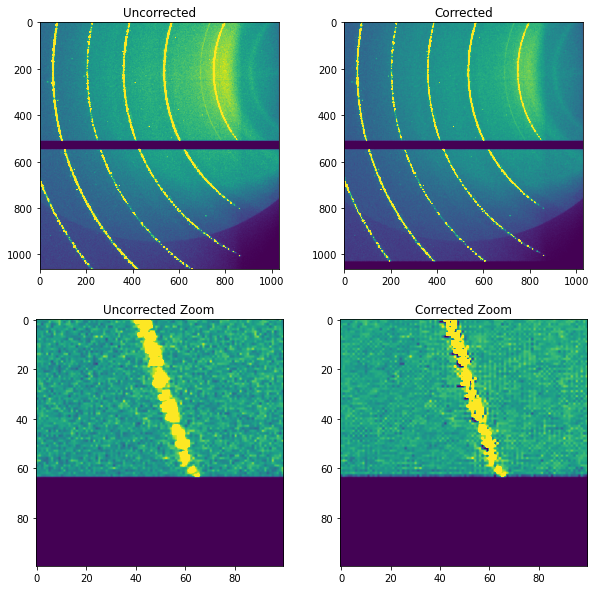

In [61]:
from cupy import meshgrid, linspace
import numpy as np
import cupy as cp
import xtrace
from functools import reduce
import warnings

warnings.simplefilter('error', UserWarning)

plt.rcParams['figure.figsize'] = [10, 10]
det_numpixels = img.shape
###############################################################################
#information of the frontal intersection point
#hit_col, hit_row and j should be given
hit_col, hit_row = meshgrid(linspace(0, det_numpixels[0], det_numpixels[0]), linspace(0, det_numpixels[1], det_numpixels[1])) # for 100 rays
#hit_col, hit_row = meshgrid(linspace(0.5, 100-0.5, 2*1000), linspace(0.5, 100-0.5, 2*1000)) # for 1M rays
hit_row = hit_row.flatten()
hit_col = hit_col.flatten()

#To mention:

det_params = {
    "mu": 3.445930 * 10**-3, #in 1/micron
    "IO": 1,
    #pixel dimentions
    "pl": pl,
    "pw": pw,
    "ph": ph,
    #detector dimentions
    "det_numpixels": det_numpixels, #number of rows in pixels, number of columns in pixels
    #detector limits in Cartesian coordinates
    "det_xlim": (0.0, pw),
    "det_ylim": (0.0, det_numpixels[1] * pl),
    "det_zlim": (0.0, det_numpixels[0] * ph),
    #Cartesian coordinates of the sample, given by the poni file 
    "sx": sx, # -dist in poni file, in micrometers
    "sy": sy, # P2 in poni file, in micrometers
    "sz": sz, # P1 in poni file, in micrometers

    #for the construction of the plane
    "Jj": 10, # positive or negative integer number related to the plane point
    #positive means either to the right or upwards
    #negative means either to the left or downwards
    #planevec
    #"planevec": np.array([[0,1,0]]), #OBS Unused
}


def regularized_richard_lucy_deconv(img, psf, smooth_coeff, iters):
    np = cp
    pixel_arr = np.array(img).reshape(-1)
    pixel_arr_itr = pixel_arr.copy()
    for _ in range(iters):
        c = psf@pixel_arr_itr
        c[c == 0] = 1
        grad = np.array(np.gradient(pixel_arr_itr.reshape(img.shape)))
        norms = np.sum(np.abs(grad),axis=0)
        norms[norms == 0] = 1
        grad /=norms
        divergence = np.gradient(grad[0],axis=0) + np.gradient(grad[1], axis=1)
        divergence_arr = divergence.reshape(-1)
        sm = psf.T@(pixel_arr/c)
        pixel_arr_itr = pixel_arr_itr*sm/(1 - smooth_coeff*divergence_arr) 
    return pixel_arr_itr.reshape(img.shape)


G = xtrace.sensor_depth_spill_psf(det_params, hit_row, hit_col)

perc = np.percentile(img, 98)
recovered_img = regularized_richard_lucy_deconv(img, G, 0.08, 100).get()
r_perc = np.percentile(recovered_img, 98)
r_n_perc = np.percentile(recov_no_reg, 100)
area = (slice(450,550), slice(350,450))
fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title("Uncorrected")
axs[0, 0].imshow(img, vmax=perc)
axs[0, 1].set_title("Corrected")
axs[0, 1].imshow(recovered_img, vmax=r_n_perc)
axs[1, 0].set_title("Uncorrected Zoom")
axs[1, 0].imshow(img[area], vmax=perc)
axs[1, 1].set_title("Corrected Zoom")
axs[1, 1].imshow(recovered_img[area], vmax=r_perc)
plt.show()

## Simple integration with corrections using numpy bincount

Note: A simple 6 line geometrical function from `maxpy_erda` module is the only exteranl function used here. The modle dependency can be simply dropped. Also `pyFAI` was needed only for conversion between geometry conventions, i.e. can be dropped as well.

In [62]:
tthFnc = mp.tth2Dsimple

In [63]:
# integration grid
print('2theta_max (deg):', np.max(tth)*rad2deg)

# people like nicely spaced data
xtth = np.linspace(0.0, 36*deg2rad, int(36./0.02)+1)

print(xtth*rad2deg)

2theta_max (deg): 36.00338616579098
[0.000e+00 2.000e-02 4.000e-02 ... 3.596e+01 3.598e+01 3.600e+01]


In [64]:
_img = recovered_img.copy() # mainly to be sure :-)

### A. No pixel-splitting

Intensity from each pixel is added to a single bin the ideal case of so called *no pixel splitting*.

A single index (*idx*) of each target bin is calculated for each pixel. Some pixels may have no contribution in the given $2\theta$ range. Such pixels have logical index (*lidx*) set to *False*.

In [65]:
_idx, _lidx = mp.ttheq_get_indexes(xtth,delta=0.0,detParams=det_params_b711,N=[],M=[],tthFnc=tthFnc)

print("idx.shape:", _idx.shape)

idx.shape: (1065, 1030)


### bincount

The azimuthal integration, not including corrections, can then be done with numpy *bincount* function.

Logical index (*lidx*) can be used to reduce the number of bincount input data. This is important
only if the integration is required for a reduced $2\theta$ range.

In [66]:
# reduce data (note: creates a copy)
_ridx  = _idx[_lidx]
_rimg  = _img[_lidx]
_rmask = mask[_lidx]
# integrate data
idata_bc = np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
ndata_bc = np.bincount(_ridx,weights=_rmask,minlength=len(xtth))

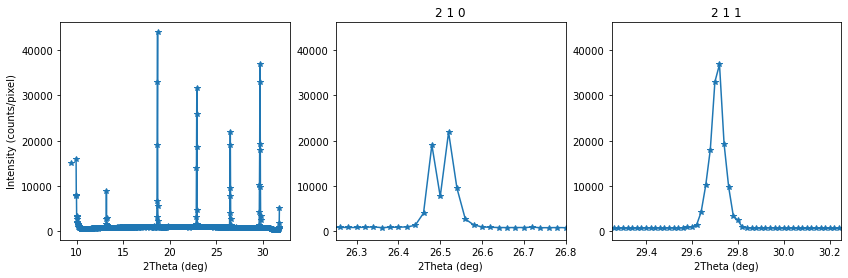

In [67]:
# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(1,3,2)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(1,3,3)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

So these are not nice peaks. The issue can be caused by:

- bad callibration, maybe the effect of detector tilt should be included
- we are quite sensitive to distribution of intensity between neighbouring pixels and their geometrical relation to the integration columns, this can be improved (smoothed) by pixel-splitting
- maybe the effect Justus suggested is the main cause of unsymmetrical *ugly* reflections
- it can be also an effect of the sample
  - $LaB_6$ has large defect free grains&crystallites
  - it has also quite some absorption
  - the sample was flat and no rotation neither spin was applyied to increase grain statistics
  - it was not standard transmission detector geometry but the sample was measured in reflection !!!
  - the rings are not continuous but rather a grainy signal is observes, on the other side, there seems to be quite enough hits on each ring